In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from asteroid.models.base_models import BaseModel
import numpy as np
import pandas as pd
import librosa as lr
import librosa.display as lrd
import soundfile as sf
import matplotlib.pyplot as plt
import time
import os
import os.path
import sys

from librosa import display as lrd
from concurrent.futures import ProcessPoolExecutor
from collections import OrderedDict
from functools import partial
from torch.multiprocessing import Process, Queue, cpu_count
from queue import Empty

from torch.utils.data import DataLoader, ConcatDataset, random_split, Subset
from asteroid.data import TimitDataset
from asteroid.data.utils import CachedWavSet, FixedMixtureSet
from tqdm import trange, tqdm

from asteroid import DCUNet, DCCRNet, DPRNNTasNet, ConvTasNet, RegressionFCNN, WaveUNet, DPTNet, Demucs, SMoLnet, Phasen, SEGAN, VAE, MetricGAN
from asteroid.models.vae import VAE_MCEM
from asteroid.engine.system import System, UNetGAN, GANSystem

from asteroid.masknn import UNetGANGenerator, UNetGANDiscriminator
from asteroid.utils.notebook_utils import show_wav

sys.path.append('../egs')

from timit_drones.evaluate import evaluate_model, eval_all, eval_all_and_plot, model_labels, metrics_names, model_colors
from timit_drones.evaluate import plot_single, aggregate_results

%load_ext autoreload
%autoreload 2

In [2]:
def get_timit_test_big_small(timit_dir, test_noise_dir, sample_rate=8000,
                             test_snrs=[-30, -25, -20, -15, -10, -5, 0], seed=42):
    timit_test_clean = TimitDataset(timit_dir, subset='test', sample_rate=sample_rate, with_path=False)
    timit_small = Subset(timit_test_clean, np.arange(len(timit_test_clean)//20))
    noises_test = CachedWavSet(test_noise_dir, sample_rate=sample_rate, precache=True)
    
    timit_test_small = FixedMixtureSet(timit_small, noises_test, snrs=test_snrs, random_seed=seed, with_snr=True)
    timit_test = FixedMixtureSet(timit_test_clean, noises_test, snrs=test_snrs, random_seed=seed, with_snr=True)
    
    return timit_test, timit_test_small

In [3]:
TIMIT_DIR_8kHZ = '../../../datasets/TIMIT'
TEST_NOISE_DIR = '../../../datasets/noises/noises-test-drones'
SAMPLE_RATE    = 8000
TEST_SNRS      = [-30, -25, -20, -15, -10, -5, 0]
SEED           = 42

In [4]:
timit_test, timit_test_small = get_timit_test_big_small(TIMIT_DIR_8kHZ, TEST_NOISE_DIR, SAMPLE_RATE, TEST_SNRS, SEED)

Precaching audio: 100%|██████████| 2/2 [00:00<00:00, 412.99it/s]


In [5]:
TIMIT_DIR_16kHZ = '../../../datasets/TIMIT_16khz'
TEST_NOISE_DIR_16kHZ = '../../../datasets/noises_16khz/noises-test-drones'

In [6]:
timit_test_16khz, timit_test_small_16khz = get_timit_test_big_small(TIMIT_DIR_16kHZ, TEST_NOISE_DIR_16kHZ, 16000, TEST_SNRS, SEED)

Precaching audio: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


In [15]:
noises_test = CachedWavSet(TEST_NOISE_DIR, sample_rate=SAMPLE_RATE, precache=True)

Precaching audio: 100%|██████████| 2/2 [00:00<00:00, 484.97it/s]


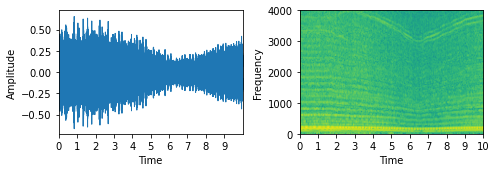

In [39]:
show_wav(noises_test[0][:80000], figsize=(7, 2.5), specgram_lib='matplotlib', save_to='noise_illustration.pdf')

In [5]:
mix, clean, snr = timit_test[3360*3]
print(snr)

-15


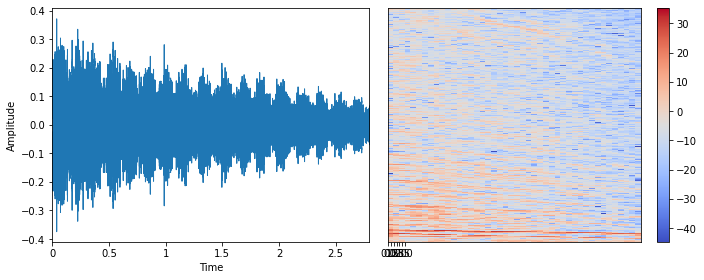

In [6]:
show_wav(mix)

In [7]:
mix2, clean2, snr2 = timit_test[3360*3+1]
print(snr2)

-15


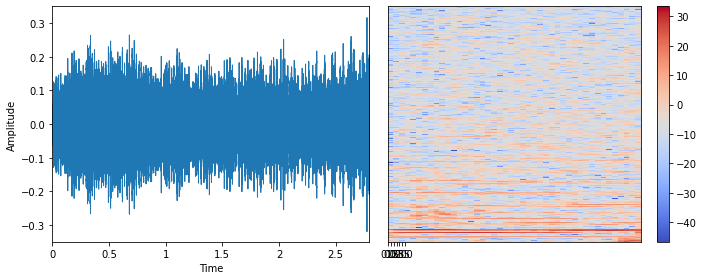

In [8]:
show_wav(mix2)

In [5]:
def show_stft(wav, n_fft, hop_length, ax=None):
    S = np.log(np.abs(lr.stft(wav, n_fft, hop_length, center=False)))
    lrd.specshow(S, sr=8000, hop_length=hop_length, y_axis='hz', x_axis='s', ax=ax)

In [6]:
mixes = [clean.numpy(), mix.numpy(), mix2.numpy()]

NameError: name 'clean' is not defined

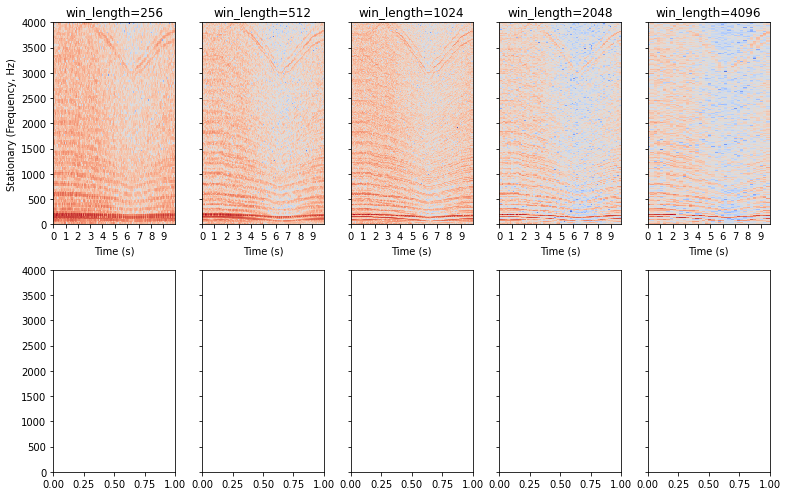

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11, 7), sharex=False, sharey=True)
n_ffts = [256, 512, 1024, 2048, 4096]

for _i in range(1):
    i = 1 - _i
    for j, n_fft in enumerate(n_ffts):
        plt.sca(axes[_i][j])
        show_stft(noises_test[_i][:80000], n_fft, n_fft // 2, ax=axes[_i][j])
        if _i == 0:
            plt.title(f'win_length={n_fft}')
            
        if j == 0:
            if _i == 0:
                plt.ylabel('Stationary (Frequency, Hz)')
            if _i == 1:
                plt.ylabel('Non-stationary (Frequency, Hz)')
        else:
            plt.ylabel(None)

fig.tight_layout()
plt.savefig('noise_stfts.pdf', bbox_inches='tight')

In [5]:
def demonstrate_models_on_sample(models, mix, clean, **kwargs):
    print('Clean speech')
    show_wav(clean, **kwargs)
    
    for model_name, model in models.items():
        if model is None:
            print('Noisy mixture')
            show_wav(mix, **kwargs)
        else:
            model.eval()
            print(model_labels[model_name])
            show_wav(model(mix).flatten(), **kwargs)

### Models evaluation

In [6]:
# unetgan_nogan = UNetGAN()
# metric_gan = MetricGAN()

# system = System.load_from_checkpoint(
#    '../../../workspace/logs/UNetGAN-generator-pretrain/version_3/checkpoints/epoch=07-val_loss=0.00.ckpt',
#     model=unetgan_nogan.generator, optimizer=None, loss_func=None, train_loader=None,val_loader=None)

# unetgan_finetuned = UNetGAN.load_from_checkpoint(
#     '../../../workspace/logs/UNetGAN-pretrained-gen/version_6/checkpoints/last.ckpt')

# metric_gan_system = GANSystem.load_from_checkpoint(
#     '../../../workspace/logs/MetricGAN/version_0/checkpoints/epoch=18-step=5972.ckpt',
#     model=metric_gan, optimizers=None, adv_loss=None, reg_loss=None, reg_weight=100, train_loader=None,
#     val_loader=None)

all_models = {
    'input': None,
    'baseline': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v1.pt'),
    'baseline_512': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_stft512.pt'),
    'baseline_1024': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_stft1024_no_sigmoid.pt'),
    'baseline_2048': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_stft2048.pt'),
    'baseline_25_15': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_snr25_15.pt'),
    'baseline_5_15': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_snr5_15.pt'),
    'baseline_sigmoid': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN.pt', use_sigmoid=True),
    'baseline_16khz': RegressionFCNN.from_pretrained('../../../workspace/models/RegressionFCNN_16khz.pt'),
    #'baseline_v2': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_v2.pt'),
    #'baseline_proper_mse': RegressionFCNN.from_pretrained('../../../workspace/models/baseline_model_fixed_mse.pt'),
#     'vae': VAE_MCEM(VAE.from_pretrained('../../../workspace/models/VAE.pt')),
    'vae': VAE.from_pretrained('../../../workspace/models/VAE.pt'),
    'vae_simple': VAE.from_pretrained('../../../workspace/models/VAE_simple.pt'),
    #'auto_encoder': VAE.from_pretrained('../../../workspace/models/AutoEncoder.pt'),
    'waveunet_v1': WaveUNet.from_pretrained('../../../workspace/models/waveunet_model_adapt.pt'),
    'waveunet_16khz': WaveUNet.from_pretrained('../../../workspace/models/WaveUNet_16khz.pt'),
    'waveunet_5_15': WaveUNet.from_pretrained('../../../workspace/models/WaveUNet_snr5_15.pt'),
    'waveunet_25_15': WaveUNet.from_pretrained('../../../workspace/models/WaveUNet_snr25_15.pt'),
    'waveunet_sisdr': WaveUNet.from_pretrained('../../../workspace/models/WaveUNet_si_sdr.pt'),
    'waveunet_lstm': WaveUNet.from_pretrained('../../../workspace/models/WaveUNet_lstm.pt'),
    'dcunet_20': DCUNet.from_pretrained('../../../workspace/models/dcunet_20_random_v2.pt', fix_length_mode="pad"),
    'dcunet_20_fixed': DCUNet.from_pretrained('../../../workspace/models/DCUNet_fixed.pt', fix_length_mode="pad"),
    'dcunet_20_512': DCUNet.from_pretrained('../../../workspace/models/DCUNet_stft512.pt', fix_length_mode="pad"),
    'dcunet_20_2048': DCUNet.from_pretrained('../../../workspace/models/DCUNet_stft2048.pt', fix_length_mode="pad"),
    'dcunet_20_25_15': DCUNet.from_pretrained('../../../workspace/models/DCUNet_snr25_15.pt', fix_length_mode="pad"),
    'dcunet_20_5_15': DCUNet.from_pretrained('../../../workspace/models/DCUNet_snr5_15.pt', fix_length_mode="pad"),
    'dcunet_20_16khz':  DCUNet.from_pretrained('../../../workspace/models/DCUNet_16khz.pt', fix_length_mode="pad"),
    'dccrn': DCCRNet.from_pretrained('../../../workspace/models/dccrn_random_v1.pt'),
    'dccrn_1024': DCCRNet.from_pretrained('../../../workspace/models/DCCRNet_stft1024.pt'),
    'dccrn_2048': DCCRNet.from_pretrained('../../../workspace/models/DCCRNet_stft2048.pt'),
    'dccrn_nolstm': DCCRNet.from_pretrained('../../../workspace/models/DCCRNet_no_lstm.pt'),
    'smolnet': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet.pt'),
    'smolnet_tms': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_TMS.pt'),
    'smolnet_cirm': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_cIRM.pt'),
    'smolnet_256': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_stft256.pt'),
    'smolnet_512': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_stft512.pt'),
    'smolnet_1024': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_stft1024.pt', dilated_layers=9),
    'smolnet_dil256': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_dil256.pt'),
    'smolnet_dil64': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_dil64.pt'),
    'smolnet_dil16': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_dil16.pt'),
    'smolnet_dil4': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_dil4.pt'),
    'smolnet_dil1': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_dil1.pt'),
    'smolnet_5_15': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_snr5_15.pt'),
    'smolnet_25_15': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_snr25_15.pt'),
    'smolnet_16khz': SMoLnet.from_pretrained('../../../workspace/models/SMoLnet_16khz.pt'),
    'dprnn': DPRNNTasNet.from_pretrained('../../../workspace/models/dprnn_model.pt'),
    'conv_tasnet': ConvTasNet.from_pretrained('../../../workspace/models/convtasnet_model.pt'),
    'dptnet': DPTNet.from_pretrained('../../../workspace/models/dptnet_model.pt'),
    'demucs': Demucs.from_pretrained('../../../workspace/models/Demucs.pt'),
    #'demucs_full': Demucs.from_pretrained('../../../workspace/models/Demucs_full.pt'),
    'segan': SEGAN.from_pretrained('../../../workspace/models/SEGAN.pt'),
    'segan-nogan': SEGAN.from_pretrained('../../../workspace/models/SEGAN-gen-only.pt'),
    #'metric-gan': metric_gan_system.model,
    #'unetgan-nogan': unetgan_nogan,
    #'unetgan': unetgan_finetuned,
    'phasen': Phasen.from_pretrained('../../../workspace/models/Phasen.pt'),
    'phasen_256': Phasen.from_pretrained('../../../workspace/models/Phasen_stft256.pt'),
    'phasen_1024': Phasen.from_pretrained('../../../workspace/models/Phasen_stft1024.pt'),
    'phasen_2048': Phasen.from_pretrained('../../../workspace/models/Phasen_stft2048.pt'),
}

In [7]:
def model_select(ls):
    return {k: all_models[k] for k in ls}

models = model_select(
    ['input', 'baseline', 
     #'vae',
     'smolnet', 
     #'smolnet_tms', 'smolnet_cirm', 
     'dcunet_20', 'dccrn', 'phasen', 'waveunet_v1', 'demucs',
     'conv_tasnet', 'dprnn', 'dptnet', 'segan']) #,'unetgan'])

models_16khz = model_select(
    ['input', 'baseline_16khz', 'smolnet_16khz', 'dcunet_20_16khz', 'waveunet_16khz'])

baselines = model_select(['input', 'baseline', 'baseline_1024', 'baseline_sigmoid'])
#smolnet_models = model_select(['input', 'baseline', 'smolnet', 'smolnet_tms', 'smolnet_cirm'])
smolnet_models = model_select(['input', 'baseline', 'smolnet'])
smolnet_dilations = model_select(
    ['input', 'smolnet', 'smolnet_dil256', 'smolnet_dil64',
     'smolnet_dil16', 'smolnet_dil4', 'smolnet_dil1'])

tf_models = model_select(
    ['input', 'baseline',
     #'vae',
     #'smolnet',
     'dcunet_20', 'dccrn', 'phasen'])

wave_models = model_select(['input', 'baseline', 'waveunet_v1', 'demucs', 'segan'])
tasnet_models = model_select(['input', 'baseline', 'conv_tasnet', 'dprnn', 'dptnet'])
best_only = model_select(['input', 'smolnet', 'dcunet_20', 'waveunet_v1', 'dptnet'])

tf_1024 = model_select(
    ['input', 'baseline_512', 'baseline_1024', 'baseline_2048', 'smolnet',
     'smolnet_1024', 'dcunet_20', 'dccrn', 'dccrn_1024',
     'phasen', 'phasen_1024'])

some_snrs = model_select(['input', 'baseline', 'baseline_5_15', 'baseline_25_15',
                          'smolnet', 'smolnet_5_15', 'smolnet_25_15',
                          'dcunet_20', 'dcunet_20_5_15', 'dcunet_20_25_15', 'waveunet_v1', 'waveunet_5_15', 'waveunet_25_15'])

#gans_comp = model_select(['input', 'unetgan-nogan', 'unetgan', 'segan-nogan', 'segan'])

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


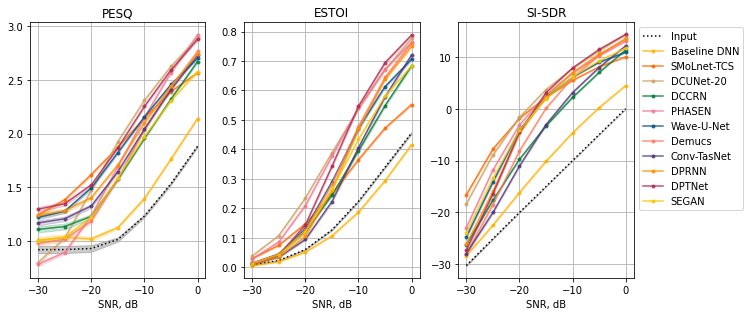

In [9]:
eval_all_and_plot(models, timit_test, '../../../workspace/eval_padded',
                  figsize=(9,4.5), plot_name='results_padded_pypesq.pdf', use_pypesq=True, num_workers=10)


Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating VAE
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


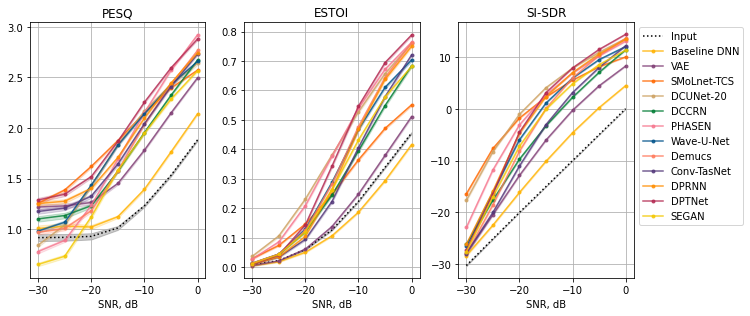

In [10]:
df = eval_all_and_plot(models, timit_test, '../../../workspace/eval_results_final',
                       figsize=(9,4.5), plot_name='results_final_pypesq.pdf', use_pypesq=True, num_workers=10)
df

In [18]:
print(df.data.round(3).to_latex())

\begin{tabular}{llrrr}
\toprule
{} &         Model &   PESQ &  ESTOI &  SI-SDR \\
\midrule
0  &  Baseline DNN &  0.119 & -0.018 &   4.187 \\
1  &   SMoLnet-TCS &  0.735 &  0.100 &  17.110 \\
2  &     DCUNet-20 &  0.594 &  0.203 &  18.166 \\
3  &         DCCRN &  0.450 &  0.093 &  10.416 \\
4  &        PHASEN &  0.468 &  0.194 &  16.189 \\
5  &    Wave-U-Net &  0.595 &  0.124 &  13.763 \\
6  &        Demucs &  0.428 &  0.124 &  12.345 \\
7  &   Conv-TasNet &  0.532 &  0.081 &   9.786 \\
8  &         DPRNN &  0.598 &  0.109 &  14.706 \\
9  &        DPTNet &  0.724 &  0.160 &  15.037 \\
10 &         SEGAN &  0.323 &  0.106 &  12.654 \\
\bottomrule
\end{tabular}



In [7]:
results = eval_all(models, timit_test, '../../../workspace/eval_results_final', use_pypesq=True, num_workers=10)
results

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


{'input':         snr      pesq     estoi     si_sdr
 0     -30.0  0.694193 -0.031301 -28.715515
 1     -30.0  2.572821  0.054970 -32.940716
 2     -30.0  0.239118 -0.009042 -29.500916
 3     -30.0  0.598385 -0.004113 -29.916630
 4     -30.0  0.963216  0.009129 -31.688826
 ...     ...       ...       ...        ...
 23515   0.0  1.804879  0.500522   0.012119
 23516   0.0  1.634856  0.438083  -0.097114
 23517   0.0  1.860196  0.462844   0.017074
 23518   0.0  1.925197  0.502280   0.015295
 23519   0.0  1.933858  0.496479  -0.019032
 
 [23520 rows x 4 columns],
 'baseline':         snr      pesq     estoi     si_sdr
 0     -30.0  0.772419 -0.075734 -26.462624
 1     -30.0  0.979723  0.089452 -35.610828
 2     -30.0  2.432085  0.005803 -27.610748
 3     -30.0  0.678240  0.005678 -29.974205
 4     -30.0  2.095803  0.017861 -30.048729
 ...     ...       ...       ...        ...
 23515   0.0  2.035045  0.444109   5.075678
 23516   0.0  1.972886  0.349101   4.224403
 23517   0.0  2.093754  0.

In [12]:
results['input'][results['input']['snr'].isin([-25, -20, -15, -10])]

snr      pesq     estoi     si_sdr
3360  -25.0  1.085485  0.021205 -24.548958
3361  -25.0  0.682441 -0.046983 -24.846939
3362  -25.0  0.582779  0.005706 -24.683876
3363  -25.0  0.445790  0.005562 -25.493084
3364  -25.0  1.163452 -0.015975 -24.711895
...     ...       ...       ...        ...
16795 -10.0  1.261163  0.290654  -9.866156
16796 -10.0  0.993399  0.219876 -10.033866
16797 -10.0  1.228795  0.295572  -9.946806
16798 -10.0  1.311364  0.229570 -10.011951
16799 -10.0  1.414255  0.283135 -10.002338

[13440 rows x 4 columns]

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net (+LSTM)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN (no LSTM)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


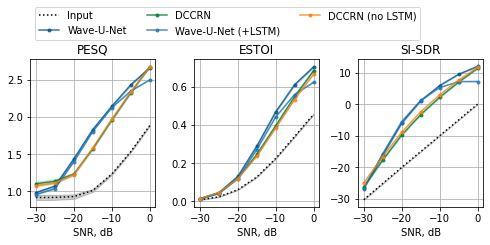

In [14]:
eval_all_and_plot(model_select(['input', 'waveunet_v1', 'dccrn', 'waveunet_lstm', 'dccrn_nolstm']),
                  timit_test, '../../../workspace/eval_results_final',
                  figsize=(7,3), plot_name='results_lstms.pdf', use_pypesq=True, num_workers=10,
                  legend='top', legend_ncol=3, legend_pad=0.1)

Clean speech


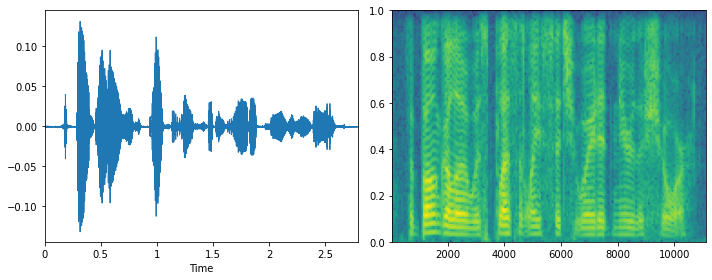

Noisy mixture


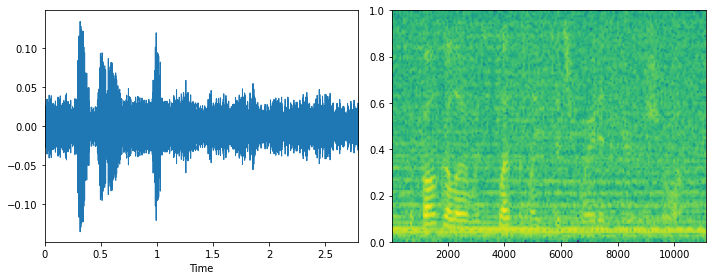

Wave-U-Net


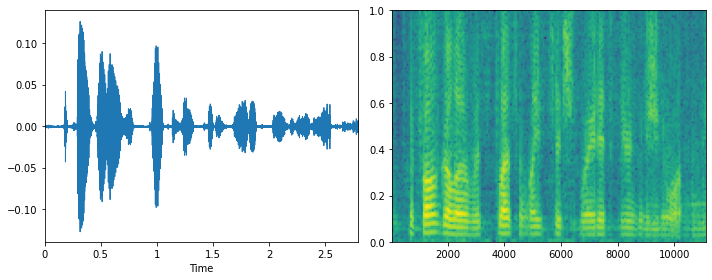

Wave-U-Net (SI-SDR loss)


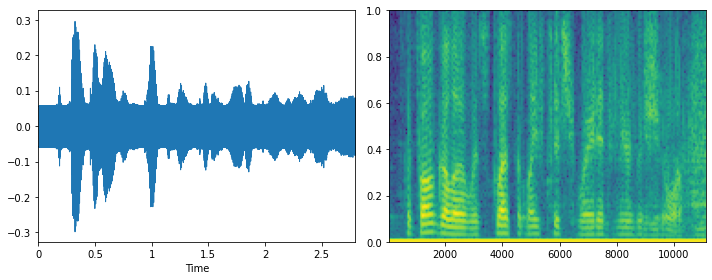

Wave-U-Net (+LSTM)


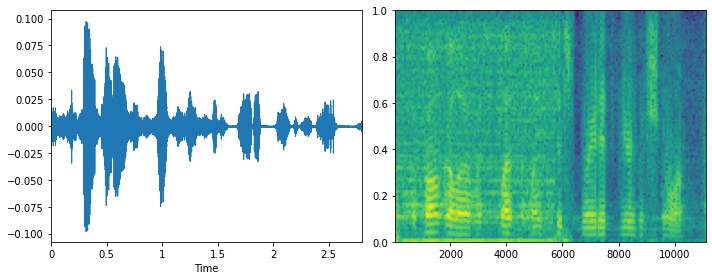

In [23]:
demonstrate_models_on_sample(
    model_select(['input', 'waveunet_v1', 'waveunet_sisdr', 'waveunet_lstm']),
    mix2, clean2, specgram_lib='matplotlib')

In [9]:
eval_all_and_plot(timit_test_16khz, timit_test, '../../../workspace/eval_results_16khz',
                  figsize=(9,4.5), plot_name='results_16khz.pdf', sample_rate=16000, use_pypesq=True, num_workers=10)

Evaluating Input


Evaluating and calculating scores:   1%|          | 266/23520 [00:10<15:14, 25.43it/s]Process Process-8:
Process Process-10:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-7:
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/site-packages/pypesq/__init__.py:53: UserWarning: Processing Error! return NaN
  warnings.warn('Processing Error! return NaN')
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
  

KeyboardInterrupt: 

Process Process-6:
Traceback (most recent call last):
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "../egs/timit_drones/evaluate.py", line 80, in eval_process
    inp = input_queue.get()
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/queues.py", line 97, in get
    res = self._recv_bytes()
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/connection.py", line 421, in _recv_bytes
    return self._recv(size)
  File "/home/flyingleafe/anaconda3/envs/phd/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline (-5, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline (-25, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (-5, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (-25, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20 (-5, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20 (-25, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


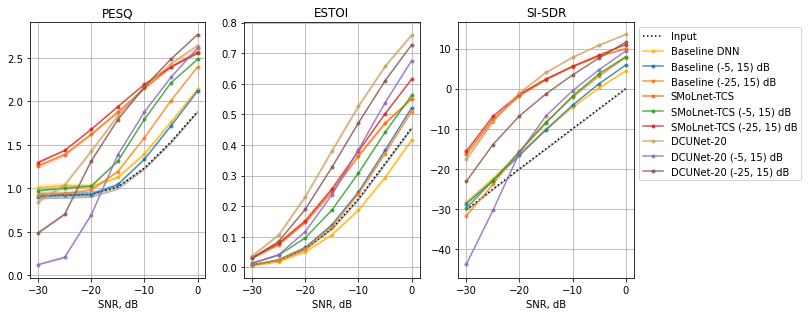

In [57]:
eval_all_and_plot(some_snrs, timit_test, '../../../workspace/eval_results_final',
                  figsize=(9,4.5), plot_name='results_some_snrs.pdf', use_pypesq=True, num_workers=10)

In [9]:
snrs_results = aggregate_results(
    eval_all(some_snrs, timit_test, '../../../workspace/eval_results_final', use_pypesq=True, num_workers=10))

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline (-5, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline (-25, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (-5, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (-25, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20 (-5, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20 (-25, 15) dB
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net (-5, 15) dB
Metrics already calculated:  

In [10]:
model_groups = {
    'baseline': ['input', 'baseline', 'baseline_5_15', 'baseline_25_15'],
    'smolnet': ['input', 'smolnet', 'smolnet_5_15', 'smolnet_25_15'],
    'dcunet_20': ['input', 'dcunet_20', 'dcunet_20_5_15', 'dcunet_20_25_15'],
    'waveunet_v1': ['input', 'waveunet_v1', 'waveunet_5_15', 'waveunet_25_15']
}

line_colors = ['black', 'tab:blue', 'tab:orange', 'tab:green']

metrics = ['pesq', 'estoi', 'si_sdr']

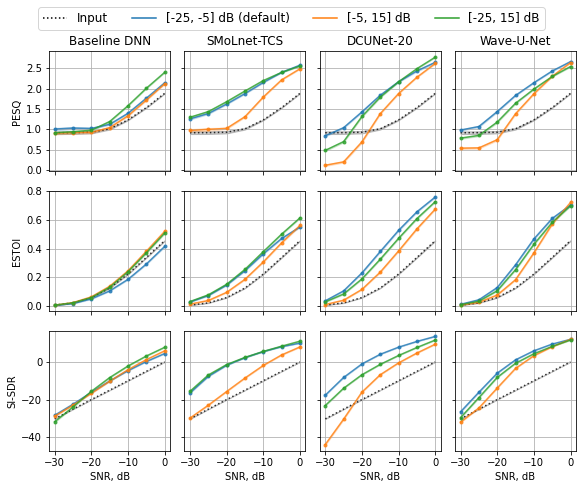

In [19]:
from matplotlib import lines

fig, axes = plt.subplots(figsize=(8.2, 6.5), nrows=len(metrics), ncols=len(model_groups), sharex=True, sharey='row')

for i, metric in enumerate(metrics):
    for j, (group, models) in enumerate(model_groups.items()):
        plt.sca(axes[i, j])
        for k, model_name in enumerate(models):
            if model_name is None:
                continue

            color = line_colors[k]
            line_kwargs = {'c': color, 'alpha': 0.8}
            if model_name != 'input':
                line_kwargs['marker'] = '.'
            else:
                line_kwargs['ls'] = 'dotted'
            fill_kwargs = {'color': color}
            plot_single(snrs_results[model_name][metric], None, axes[i, j], line_kwargs, fill_kwargs)
        
        plt.grid(which='both')
        
        if j == 0:
            plt.ylabel(metrics_names[metric])
        
        if i == 0:
            plt.title(model_labels[group])
        elif i == len(metrics)-1:
            plt.xlabel('SNR, dB')
    
fig.tight_layout()

lines = [lines.Line2D(np.arange(10), np.arange(10), linestyle='dotted', color='black')] + [lines.Line2D(np.arange(10), np.arange(10), color=c) for c in line_colors[1:]]
fig.legend(handles=lines, labels=['Input', '[-25, -5] dB (default)', '[-5, 15] dB', '[-25, 15] dB'],
           loc='upper center', ncol=5, bbox_to_anchor=(0, 0, 1, 1.05), fontsize='large')

plt.savefig('results_snr_ranges.pdf', bbox_inches='tight')

In [63]:
print(df.data.to_latex(columns=['Model', 'PESQ', 'ESTOI', 'SI-SDR']))

\begin{tabular}{llrrr}
\toprule
{} &         Model &  PESQ &  ESTOI &  SI-SDR \\
\midrule
0  &  Baseline DNN &  12.5 &  -12.7 &    26.9 \\
1  &   SMoLnet-TCS &  57.3 &   52.4 &   100.0 \\
2  &   SMoLnet-TMS &  50.0 &   55.2 &    95.2 \\
3  &  SMoLnet-cIRM &  45.6 &   46.1 &    72.6 \\
4  &     DCUNet-20 &  47.0 &  118.2 &   108.8 \\
5  &         DCCRN &  42.3 &   65.8 &    65.6 \\
6  &        PHASEN &  45.2 &  116.2 &    95.2 \\
7  &    Wave-U-Net &  48.9 &   82.4 &    80.9 \\
8  &        Demucs &  42.1 &   89.9 &    76.3 \\
9  &   Conv-TasNet &  48.8 &   67.2 &    63.2 \\
10 &         DPRNN &  53.4 &   83.4 &    87.1 \\
11 &        DPTNet &  63.2 &  107.5 &    89.1 \\
12 &         SEGAN &  29.2 &   72.3 &    74.1 \\
13 &       UNetGAN &   6.3 &  -23.0 &    -7.7 \\
\bottomrule
\end{tabular}



In [18]:
all_results = eval_all(models, timit_test, '../../../workspace/eval_results_final', use_pypesq=True, num_workers=10)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TMS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-cIRM
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_

In [20]:
agg_results = aggregate_results(all_results)

In [23]:
inp = agg_results['input']

In [39]:
def transform_df(df):
    metrics = ['pesq', 'estoi', 'si_sdr']
    
    agg_df = df.groupby('snr').agg({
        metric: ['mean', 'std', 'count'] for metric in metrics
    })
    for m in metrics:
        agg_df[(m, 'mean_std')] = agg_df[(m, 'std')] / agg_df[(m, 'count')].apply(np.sqrt)
        agg_df = agg_df.drop([(m, 'std'), (m, 'count')], axis=1)
    
    return agg_df

In [40]:
transform_df(all_results['input'])

pesq     estoi     si_sdr      pesq     estoi    si_sdr
           mean      mean       mean  mean_std  mean_std  mean_std
snr                                                               
-30.0  0.917847  0.007874 -30.251689  0.011374  0.000494  0.042164
-25.0  0.919964  0.023219 -25.107530  0.011060  0.000512  0.019466
-20.0  0.930191  0.060546 -20.014239  0.010368  0.000565  0.010675
-15.0  1.013210  0.126956 -15.013188  0.006502  0.000677  0.006357
-10.0  1.232321  0.223909 -10.007427  0.004097  0.000846  0.003312
-5.0   1.532749  0.339342  -5.000841  0.003633  0.001015  0.001937
 0.0   1.882603  0.455950  -0.000380  0.003157  0.001073  0.001061

In [ ]:
stationary_xs = timit_test.mapping[:, 1].astype(bool)
nonstationary_xs = np.logical_not(stationary_xs)

In [ ]:
eval_all_and_plot(models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(9,4.5), plot_name='results_final_stationary_pypesq.pdf',
                  use_pypesq=True, num_workers=10, subset_ixs=stationary_xs)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TMS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-cIRM
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_

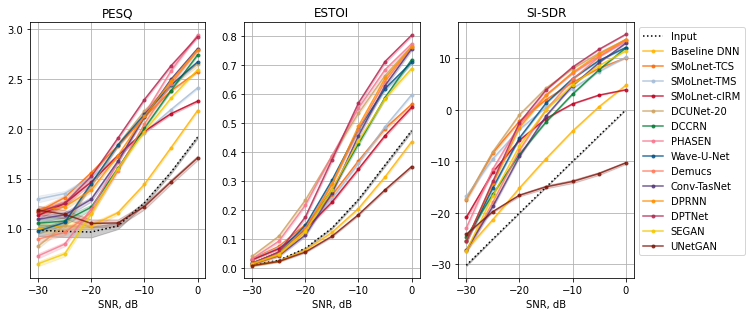

In [29]:
eval_all_and_plot(models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(9,4.5), plot_name='results_final_nonstationary_pypesq.pdf',
                  use_pypesq=True, num_workers=10, subset_ixs=nonstationary_xs)

In [16]:
input_res = pd.read_csv('../../../workspace/eval_results_final/input.csv')
dcunet_res = pd.read_csv('../../../workspace/eval_results_final/dcunet_20.csv')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


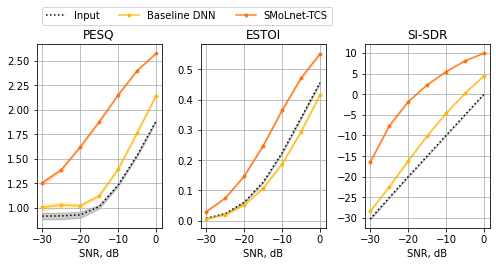

In [20]:
eval_all_and_plot(smolnet_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(7, 3.5), plot_name='results_final_existing_pypesq.pdf', use_pypesq=True, num_workers=10,
                  legend='top')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating A-VAE
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


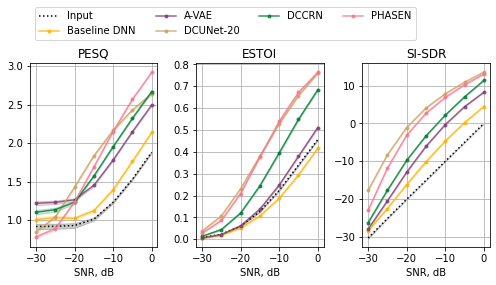

In [16]:
eval_all_and_plot(tf_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(7, 3.5), plot_name='results_final_tf2_pypesq.pdf', use_pypesq=True, num_workers=10,
                  legend='top', legend_ncol=4, legend_pad=0.1)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating VAE
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


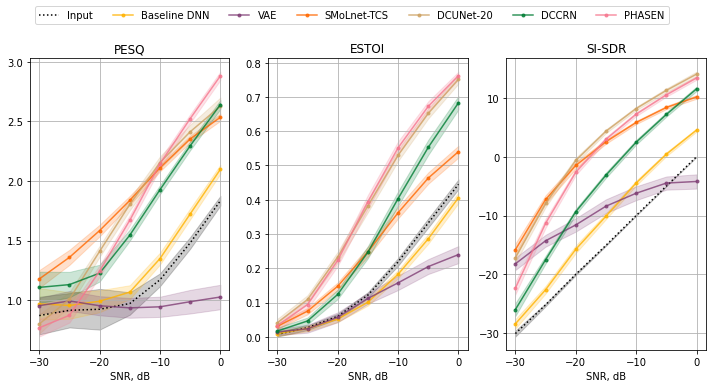

In [17]:
eval_all_and_plot(tf_models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  figsize=(10, 5), plot_name='results_final_tf_small_pypesq.pdf', use_pypesq=True, num_workers=10,
                  legend='top', legend_ncol=7, legend_pad=0.1)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


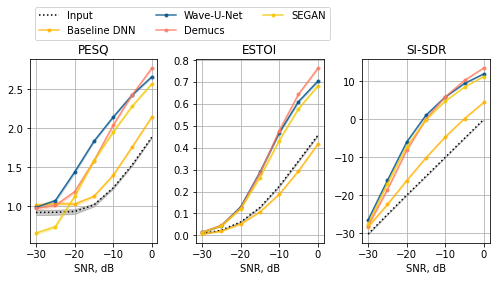

In [21]:
eval_all_and_plot(wave_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(7,3.5), plot_name='results_final_wave_pypesq.pdf', use_pypesq=True, num_workers=10,
                  legend='top')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


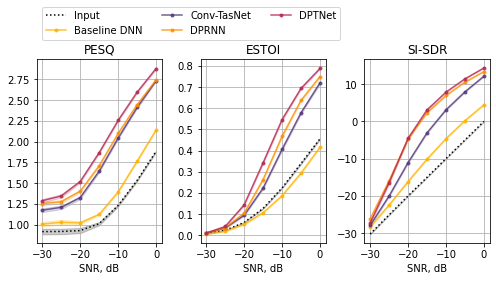

In [19]:
eval_all_and_plot(tasnet_models, timit_test, '../../../workspace/eval_results_final',
                  figsize=(7, 3.5), plot_name='results_final_tasnet_pypesq.pdf', use_pypesq=True, num_workers=10,
                  legend='top')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


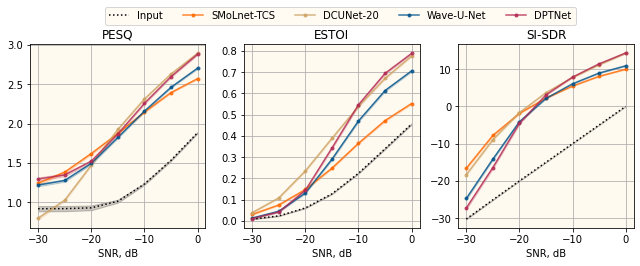

In [11]:
eval_all_and_plot(best_only, timit_test, '../../../workspace/eval_padded',
                  figsize=(9, 3.5), plot_name='results_padded_best_pypesq.pdf', use_pypesq=True, num_workers=10,
                  legend='top', legend_ncol=5, legend_pad_left=0.4, ax_bgcol='floralwhite')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 256)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 64)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 16)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 4)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 1)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


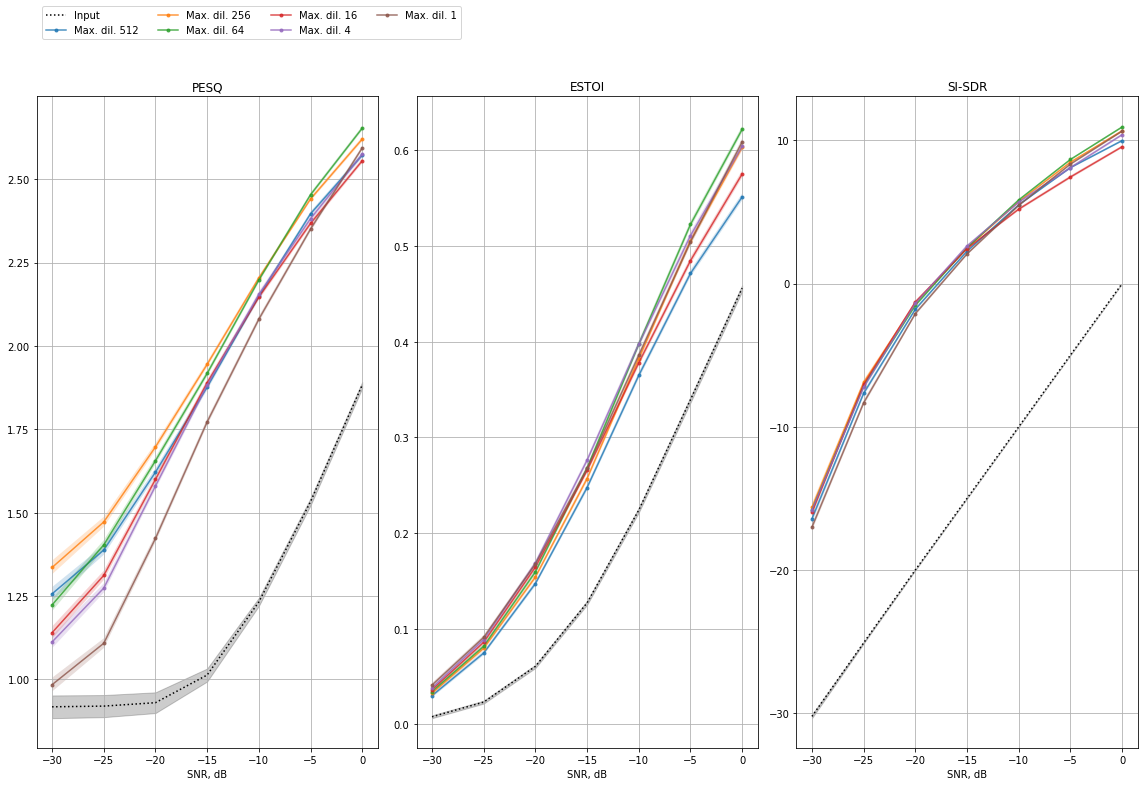

In [25]:
labels = {
    'input': 'Input',
    'smolnet': 'Max. dil. 512',
    'smolnet_dil256': 'Max. dil. 256',
    'smolnet_dil64': 'Max. dil. 64',
    'smolnet_dil16': 'Max. dil. 16',
    'smolnet_dil4': 'Max. dil. 4',
    'smolnet_dil1': 'Max. dil. 1',
}

df = eval_all_and_plot(smolnet_dilations,  timit_test, '../../../workspace/eval_results_final',
                       figsize=(16, 10), #plot_name='results_final_smolnet_dilations.pdf',
                       legend='top', legend_ncol=4, num_workers=10, use_pypesq=True, labels=labels, fixed_colors=False)

In [40]:
df

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


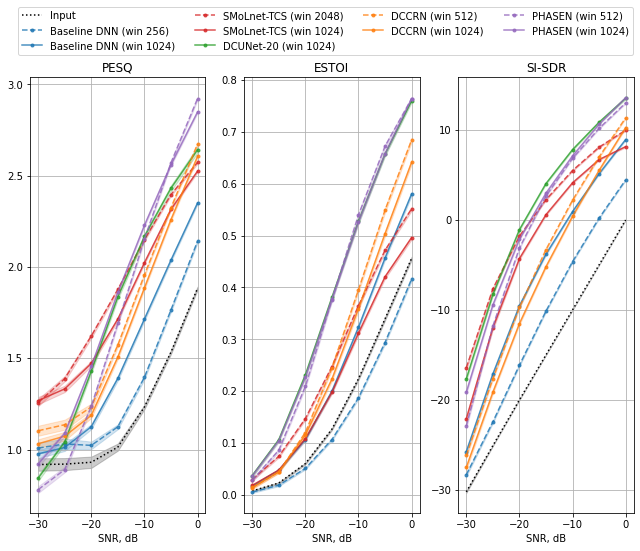

In [51]:
labels = {
    'input': 'Input',
    'baseline': 'Baseline DNN (win 256)',
    'baseline_1024': 'Baseline DNN (win 1024)',
    'smolnet': 'SMoLnet-TCS (win 2048)',
    'smolnet_1024': 'SMoLnet-TCS (win 1024)',
    'dcunet_20': 'DCUNet-20 (win 1024)',
    'dccrn': 'DCCRN (win 512)',
    'dccrn_1024': 'DCCRN (win 1024)',
    'phasen': 'PHASEN (win 512)',
    'phasen_1024': 'PHASEN (win 1024)',
}

lines = {
    'baseline': {'c': 'tab:blue', 'ls': '--'},
    'baseline_1024': {'c': 'tab:blue', 'ls': '-'},
    'smolnet': {'c': 'tab:red', 'ls': '--'},
    'smolnet_1024': {'c': 'tab:red', 'ls': '-'},
    'dcunet_20': {'c': 'tab:green', 'ls': '-'},
    'dccrn': {'c': 'tab:orange', 'ls': '--'},
    'dccrn_1024': {'c': 'tab:orange', 'ls': '-'},
    'phasen': {'c': 'tab:purple', 'ls': '--'},
    'phasen_1024': {'c': 'tab:purple', 'ls': '-'}
}

for k, v in lines.items():
    v['marker'] = '.'
    v['alpha'] = 0.8

eval_all_and_plot(tf_1024, timit_test, '../../../workspace/eval_results_final',
                  figsize=(9, 7), plot_name='results_final_tf1024_pypesq.pdf', lines=lines, labels=labels,
                  use_pypesq=True, num_workers=10, legend='top',
                  legend_ncol=4, legend_pad=0.04, legend_pad_left=-0.1)

In [40]:
model_groups = {
    'baseline': ['baseline', 'baseline_512', 'baseline_1024', 'baseline_2048'],
    'smolnet': ['smolnet_256', 'smolnet_512', 'smolnet_1024', 'smolnet'],
    'dcunet_20': [None, 'dcunet_20_512', 'dcunet_20', 'dcunet_20_2048'],
    'dccrn': [None, 'dccrn', 'dccrn_1024', 'dccrn_2048'],
    'phasen': ['phasen_256', 'phasen', 'phasen_1024', 'phasen_2048'],
}

linestyles = ['dotted', 'dotted', 'dashed', 'solid', 'dashdot']

metrics = ['pesq', 'estoi', 'si_sdr']

included_model_names = [m for m in set(sum(model_groups.values(), [])) if m is not None] + ['input']
included_models = {m: all_models[m] for m in included_model_names}
included_results = aggregate_results(
    eval_all(included_models, timit_test, '../../../workspace/eval_results_final', use_pypesq=True, num_workers=10))

Evaluating SMoLnet (win 256)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20 (win 512)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN (win 2048)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet (win 512)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN v2
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN (win 2048)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN (win 2048)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN (win 256)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Ev

In [41]:
included_results = {k: df.loc[[-10, -15, -20, -25]] for k, df in included_results.items()}

In [42]:
included_results

{'smolnet_256':          pesq                     estoi                     si_sdr            \
          mean       std count      mean       std count       mean       std   
 snr                                                                            
 -10  2.000730  0.152122  3360  0.327729  0.064695  3360   4.487837  1.311239   
 -15  1.680101  0.201834  3360  0.199817  0.053451  3360   0.173689  1.691321   
 -20  1.430800  0.287435  3360  0.102296  0.044081  3360  -6.085271  2.798817   
 -25  1.327988  0.383178  3360  0.041242  0.037836  3360 -15.353496  4.205907   
 
            
     count  
 snr        
 -10  3360  
 -15  3360  
 -20  3360  
 -25  3360  ,
 'phasen':          pesq                     estoi                     si_sdr            \
          mean       std count      mean       std count       mean       std   
 snr                                                                            
 -10  2.152138  0.184971  3360  0.539642  0.082677  3360   6.861515  1.

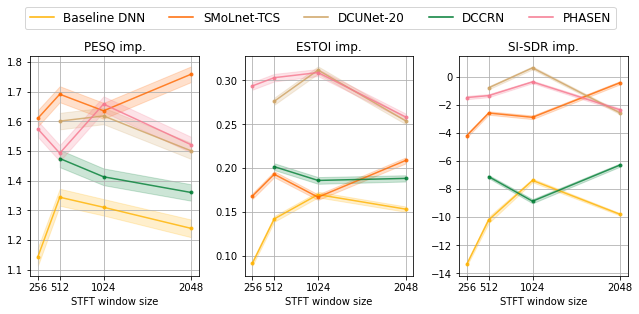

In [43]:
from matplotlib import lines

fig, axes = plt.subplots(figsize=(9, 4), nrows=1, ncols=len(metrics))

xs = [256, 512, 1024, 2048]

for i, metric in enumerate(metrics):
    plt.sca(axes[i])
    #axes[i].set_xscale('log')
    
    input_res = included_results['input'][metric]
    input_mean = input_res['mean']
    input_std = input_res['std'] / np.sqrt(input_res['count'])
    
    for j, (group, models) in enumerate(model_groups.items()):
        model_means = []
        model_stds = []
        
        for k, model_name in enumerate(models):
            if model_name is not None:
                model_res = included_results[model_name][metric]
                model_mean = model_res['mean']
                model_std = model_res['std'] / np.sqrt(model_res['count'])
                improvement_std = 3 * np.sqrt(input_std**2 + model_std**2)
                model_means.append(model_mean.mean())
                model_stds.append(improvement_std.mean())
                
        model_means = np.array(model_means)
        model_stds = np.array(model_stds)
        model_xs = xs if len(model_means) == len(xs) else xs[1:]
        
        line_kwargs = {'c': model_colors[group], 'alpha': 0.8, 'marker': '.'}
        fill_kwargs = {'color': model_colors[group]}
        
        plt.plot(model_xs, model_means, **line_kwargs)
        plt.fill_between(model_xs, model_means - model_stds, model_means + model_stds, alpha=0.2, **fill_kwargs)
        
        plt.title(metrics_names[metric]+' imp.')
        plt.xlabel('STFT window size')
        plt.xticks(xs, [str(x) for x in xs])
        plt.grid(which='both')
        
fig.tight_layout()

lines = [lines.Line2D(np.arange(10), np.arange(10), color=model_colors[m]) for m in model_groups.keys()]
labels = [model_labels[m] for m in model_groups.keys()]
fig.legend(handles=lines, labels=labels,
           loc='upper center', ncol=5, bbox_to_anchor=(0, 0, 1, 1.1), fontsize='large')

plt.savefig('results_stft_15db.pdf', bbox_inches='tight')

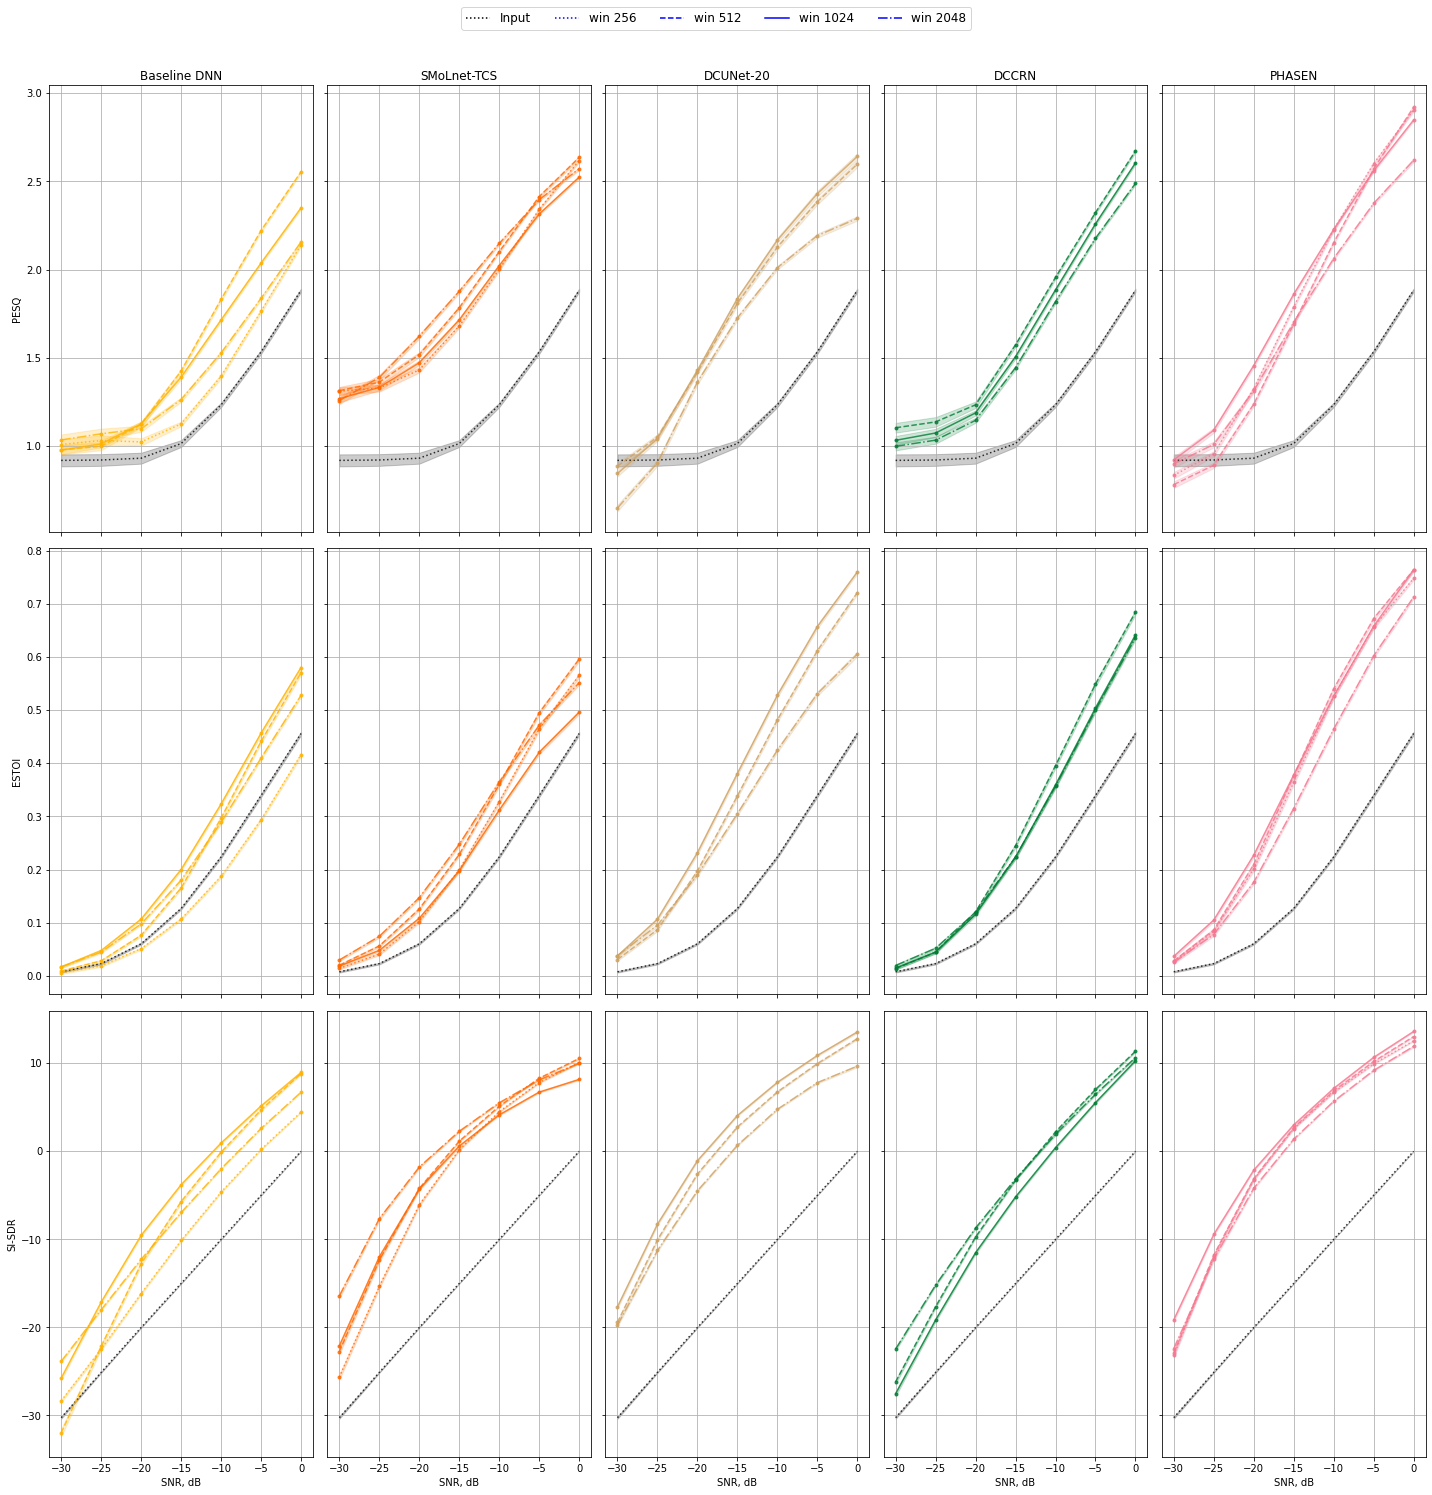

In [23]:
from matplotlib import lines

fig, axes = plt.subplots(figsize=(20, 20), nrows=len(metrics), ncols=len(model_groups), sharex=True, sharey='row')

for i, metric in enumerate(metrics):
    for j, (group, models) in enumerate(model_groups.items()):
        plt.sca(axes[i, j])
        for k, model_name in enumerate(models):
            if model_name is None:
                continue
                
            color = 'black' if model_name == 'input' else model_colors[group]
            ls = linestyles[k]
            line_kwargs = {'c': color, 'ls': ls, 'alpha': 0.8}
            if model_name != 'input':
                line_kwargs['marker'] = '.'
            fill_kwargs = {'color': color}
            plot_single(included_results[model_name][metric], None, axes[i, j], line_kwargs, fill_kwargs)
        
        plt.grid(which='both')
        
        if j == 0:
            plt.ylabel(metrics_names[metric])
        
        if i == 0:
            plt.title(model_labels[group])
        elif i == len(metrics)-1:
            plt.xlabel('SNR, dB')
    
fig.tight_layout()

lines = [lines.Line2D(np.arange(10), np.arange(10), linestyle='dotted', color='black')] + [lines.Line2D(np.arange(10), np.arange(10), linestyle=ls, color='blue') for ls in linestyles[1:]]
fig.legend(handles=lines, labels=['Input', 'win 256', 'win 512', 'win 1024', 'win 2048'],
           loc='upper center', ncol=5, bbox_to_anchor=(0, 0, 1, 1.04), fontsize='large')

#plt.savefig('results_tf_sizes.pdf', bbox_inches='tight')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating UNetGAN (MSE loss only)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating UNetGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN (L1 loss only)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


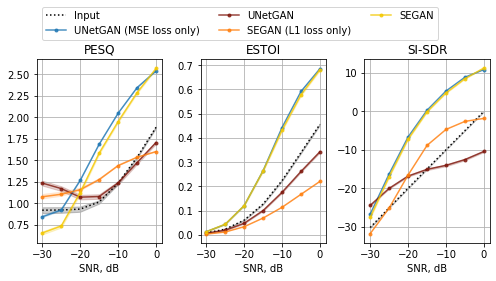

In [14]:
eval_all_and_plot(gans_comp, timit_test, '../../../workspace/eval_results_final',
                  figsize=(7,3.5), plot_name='results_final_gans_pypesq.pdf',
                  use_pypesq=True, num_workers=10, legend='top')

In [17]:
all_results = eval_all(models, timit_test, '../../../workspace/eval_results_final', use_pypesq=True, num_workers=10)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating A-VAE
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


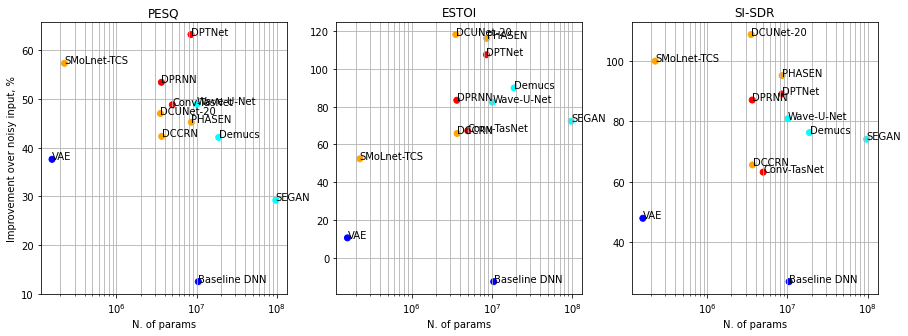

In [18]:
metrics = ['pesq', 'estoi', 'si_sdr']
avgs = {k: df[metrics].mean(axis=0) for k, df in all_results.items()}
input_avgs = avgs['input']

mean_results = {
    k: np.round(((res - input_avgs) / np.abs(input_avgs)) * 100, 1)
    for k, res in avgs.items() if k != 'input' 
}

model_sizes = {
    k: sum(p.numel() for p in all_models[k].parameters() if p.requires_grad)
    for k in mean_results.keys()
}

fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(15, 5))

def make_color(name):
    if name in ['baseline', 'vae']:
        return 'blue'
    if name in ['smolnet', 'dcunet_20', 'dccrn', 'phasen']:
        return 'orange'
    if name in ['waveunet_v1', 'demucs', 'segan']:
        return 'cyan'
    else:
        return 'red'
    
colors = [make_color(k) for k in model_sizes.keys()]

for i, metric in enumerate(metrics):
    plt.sca(axes[i])
    plt.grid(which='both')
    plt.title(metrics_names[metric])
    plt.xlabel('N. of params')
    xs = list(model_sizes.values())
    ys = [mean_results[k][metric] for k in model_sizes.keys()]
    plt.scatter(xs, ys, c=colors)
    
    axes[i].set_xscale('log')
    
    if i == 0:
        plt.ylabel('Improvement over noisy input, %')
    
    for i, key in enumerate(model_sizes.keys()):
        plt.annotate(model_labels[key], (xs[i], ys[i]), fontsize='medium')

plt.savefig('scores_against_params.pdf', bbox_inches='tight')

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


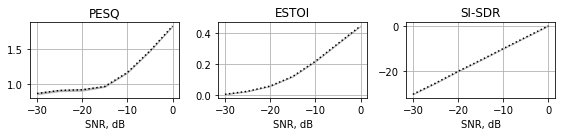

In [49]:
eval_all_and_plot({'input': None}, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  plot_name='pesq_variance.pdf', figsize=(8, 2), num_workers=10, use_pypesq=True, legend=False)

In [45]:
phasen = all_models['phasen']

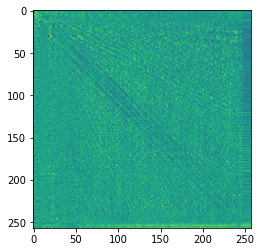

In [56]:
plt.imshow(phasen.masker.tsb[0].ftb1.linear.weight.view(257, 257).detach().numpy())

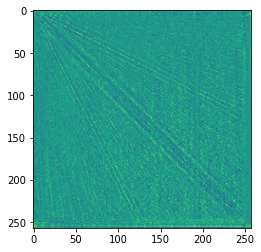

In [57]:
plt.imshow(phasen.masker.tsb[0].ftb2.linear.weight.view(257, 257).detach().numpy())

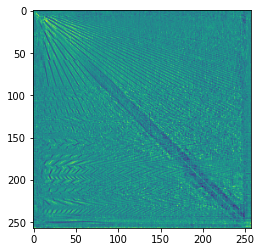

In [58]:
plt.imshow(phasen.masker.tsb[1].ftb1.linear.weight.view(257, 257).detach().numpy())

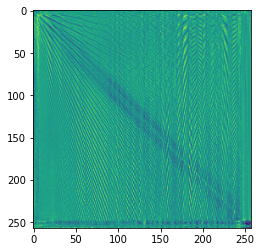

In [60]:
plt.imshow(phasen.masker.tsb[1].ftb2.linear.weight.view(257, 257).detach().numpy())

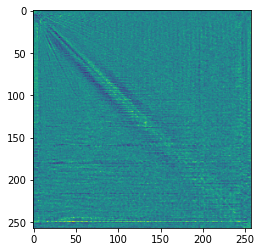

In [61]:
plt.imshow(phasen.masker.tsb[2].ftb1.linear.weight.view(257, 257).detach().numpy())

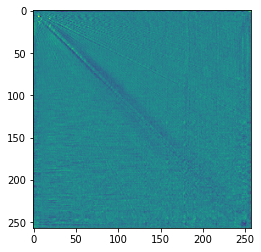

In [62]:
plt.imshow(phasen.masker.tsb[2].ftb2.linear.weight.view(257, 257).detach().numpy())

In [24]:
import timeit

def time_evaluate_cpu(models, number=1, stft_only=False):
    orig_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    with torch.no_grad():
        inp = torch.rand(16384)
        times = {}
        for name, model in models.items():
            if model is None:
                continue
            
            print(f'Running {name}')
            model.eval()
            if not stft_only:
                times[name] = timeit.timeit('_ = model(inp)', number=number, globals=locals()) / number
            else:
                times[name] = timeit.timeit('_ = model.decoder(model.encoder(inp))',
                                            number=number, globals=locals()) / number

    torch.set_num_threads(orig_threads)
    return times

In [25]:
tf_models_all = {
    k: all_models[k] for k in 
    ['input', 'baseline', 'vae', 'smolnet', 
     'dcunet_20', 'dccrn', 'phasen', 'conv_tasnet', 'dprnn', 'dptnet']
}

In [30]:
%%time
cpu_times = time_evaluate_cpu(models, number=100)
cpu_times

Running baseline
Running vae
Running smolnet
Running dcunet_20
Running dccrn
Running phasen
Running waveunet_v1
Running demucs
Running conv_tasnet
Running dprnn
Running dptnet
Running segan
CPU times: user 15min 13s, sys: 578 ms, total: 15min 14s
Wall time: 15min 14s


{'baseline': 0.10116063473047689,
 'vae': 0.01894721037009731,
 'smolnet': 0.20638378759031184,
 'dcunet_20': 1.492149899629876,
 'dccrn': 0.6305484694393817,
 'phasen': 0.6113420763902832,
 'waveunet_v1': 0.12059821218950674,
 'demucs': 0.21516658096923494,
 'conv_tasnet': 0.9661802770290524,
 'dprnn': 1.3978930965205654,
 'dptnet': 3.186262674080208,
 'segan': 0.2029459515400231}

In [31]:
cpu_times_stft = time_evaluate_cpu(tf_models_all, number=100, stft_only=True)
cpu_times_stft

Running baseline
Running vae
Running smolnet
Running dcunet_20
Running dccrn
Running phasen
Running conv_tasnet
Running dprnn
Running dptnet


{'baseline': 0.0016152518102899194,
 'vae': 0.01625593290082179,
 'smolnet': 0.06540343726985157,
 'dcunet_20': 0.016144503189716487,
 'dccrn': 0.0050719583500176664,
 'phasen': 0.00500370524940081,
 'conv_tasnet': 0.0032952533301431686,
 'dprnn': 0.0005789231194648892,
 'dptnet': 0.0005626784998457879}

In [32]:
import pickle

with open('../../../workspace/model_cpu_times_stft.pt', 'wb') as f:
    pickle.dump(cpu_times_stft, f)

In [33]:
import pickle

with open('../../../workspace/model_cpu_times.pt', 'wb') as f:
    pickle.dump(cpu_times, f)
# with open('../../../workspace/model_cpu_times.pt', 'rb') as f:
#     cpu_times = pickle.load(f)

In [34]:
def time_evaluate_gpu(models, number=1, stft_only=False):
    with torch.no_grad():
        inp = torch.rand(16384).cuda()
        times = {}
        for name, model in models.items():
            if model is None:
                continue
            model = model.cuda()
            model.eval()
            print(f'Running {name}')
            m_times = []
            for n in range(number):
                start = torch.cuda.Event(enable_timing=True)
                end = torch.cuda.Event(enable_timing=True)
                
                start.record()
                if not stft_only:
                    _ = model(inp)
                else:
                    _ = model.decoder(model.encoder(inp))
                end.record()
                
                torch.cuda.synchronize()
                m_times.append(start.elapsed_time(end))
                
            model = model.cpu()
            times[name] = np.mean(m_times)
    return times


In [78]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
gpu_times = time_evaluate_gpu(models, number=1000)
gpu_times

Running baseline
Running smolnet
Running smolnet_tms
Running smolnet_cirm
Running dcunet_20
Running dccrn
Running phasen
Running waveunet_v1
Running demucs
Running conv_tasnet
Running dprnn
Running dptnet
Running segan
Running unetgan


{'baseline': 1.2097729626893998,
 'smolnet': 3.2434079859256744,
 'smolnet_tms': 3.2719926562309265,
 'smolnet_cirm': 3.253687882900238,
 'dcunet_20': 16.76321244621277,
 'dccrn': 21.26089310836792,
 'phasen': 18.65458242416382,
 'waveunet_v1': 5.144701665401459,
 'demucs': 8.174198359012603,
 'conv_tasnet': 17.856673379898073,
 'dprnn': 24.192640186309813,
 'dptnet': 41.59414572906494,
 'segan': 5.80100358247757,
 'unetgan': 3.27099561047554}

In [36]:
gpu_times = {'baseline': 1.2097729626893998,
 'vae': 0.52421551,
 'smolnet': 3.2434079859256744,
 'dcunet_20': 16.76321244621277,
 'dccrn': 21.26089310836792,
 'phasen': 18.65458242416382,
 'waveunet_v1': 5.144701665401459,
 'demucs': 8.174198359012603,
 'conv_tasnet': 17.856673379898073,
 'dprnn': 24.192640186309813,
 'dptnet': 41.59414572906494,
 'segan': 5.80100358247757}

In [39]:
gpu_times_stft = {'baseline': 0.16381222204864024,
 'vae': 0.4569879823759,
 'smolnet': 1.1020581859350205,
 'dcunet_20': 0.4490071393251419,
 'dccrn': 0.2550650248080492,
 'phasen': 0.25297932867705825,
 'conv_tasnet': 0.19756207913160323,
 'dprnn': 0.125046209346503,
 'dptnet': 0.1306870081461966}

In [40]:
gpu_times_stft = time_evaluate_gpu(tf_models_all, number=1000, stft_only=True)

Running baseline
Running smolnet
Running dcunet_20
Running dccrn
Running phasen
Running conv_tasnet
Running dprnn
Running dptnet


In [40]:
gpu_times_stft

{'baseline': 0.16381222204864024,
 'vae': 0.4569879823759,
 'smolnet': 1.1020581859350205,
 'dcunet_20': 0.4490071393251419,
 'dccrn': 0.2550650248080492,
 'phasen': 0.25297932867705825,
 'conv_tasnet': 0.19756207913160323,
 'dprnn': 0.125046209346503,
 'dptnet': 0.1306870081461966}

In [31]:
# with open('../../../workspace/model_gpu_times.pt', 'wb') as f:
#     pickle.dump(gpu_times, f)
with open('../../../workspace/model_gpu_times.pt', 'rb') as f:
    gpu_times = pickle.load(f)

In [46]:
cpu_times = {'baseline': 0.09962376111012418,
 'smolnet': 0.1992279304898693,
 'smolnet_tms': 0.19064655694004615,
 'smolnet_cirm': 0.1974389552298817,
 'dcunet_20': 1.1162488587602275,
 'dccrn': 0.6279223319599987,
 'phasen': 0.609927810279769,
 'waveunet_v1': 0.11986871636996511,
 'demucs': 0.2170931335500791,
 'conv_tasnet': 0.9802695447398583,
 'dprnn': 1.3860554835500078,
 'dptnet': 3.163293320639932,
 'segan': 0.20215110716002527,
 'unetgan': 0.1054270096399705}

In [55]:
del cpu_times['unetgan']
del gpu_times['unetgan']

In [41]:
cpu_times

{'baseline': 0.10116063473047689,
 'vae': 0.01894721037009731,
 'smolnet': 0.20638378759031184,
 'dcunet_20': 1.492149899629876,
 'dccrn': 0.6305484694393817,
 'phasen': 0.6113420763902832,
 'waveunet_v1': 0.12059821218950674,
 'demucs': 0.21516658096923494,
 'conv_tasnet': 0.9661802770290524,
 'dprnn': 1.3978930965205654,
 'dptnet': 3.186262674080208,
 'segan': 0.2029459515400231}

In [42]:
gpu_times

{'baseline': 1.2097729626893998,
 'vae': 0.52421551,
 'smolnet': 3.2434079859256744,
 'dcunet_20': 16.76321244621277,
 'dccrn': 21.26089310836792,
 'phasen': 18.65458242416382,
 'waveunet_v1': 5.144701665401459,
 'demucs': 8.174198359012603,
 'conv_tasnet': 17.856673379898073,
 'dprnn': 24.192640186309813,
 'dptnet': 41.59414572906494,
 'segan': 5.80100358247757}

In [43]:
len(cpu_times)

12

In [47]:
df = pd.DataFrame(columns=['Model', 'CPU', 'GPU', 'CPU_stft', 'GPU_stft'], index=np.arange(len(cpu_times)))
df['Model'] = [model_labels[m] for m in cpu_times.keys()]
df['CPU'] = [np.round(s * 1000, 2) for s in cpu_times.values()]
df['GPU'] = [np.round(ms, 2) for ms in gpu_times.values()]
df['CPU_stft'] = [cpu_times_stft.get(m, 0)*1000 for m in cpu_times.keys()]
df['GPU_stft'] = [gpu_times_stft.get(m, 0) for m in gpu_times.keys()]

In [48]:
df

Model      CPU    GPU   CPU_stft  GPU_stft
0   Baseline DNN   101.16   1.21   1.615252  0.163812
1            VAE    18.95   0.52  16.255933  0.456988
2    SMoLnet-TCS   206.38   3.24  65.403437  1.102058
3      DCUNet-20  1492.15  16.76  16.144503  0.449007
4          DCCRN   630.55  21.26   5.071958  0.255065
5         PHASEN   611.34  18.65   5.003705  0.252979
6     Wave-U-Net   120.60   5.14   0.000000  0.000000
7         Demucs   215.17   8.17   0.000000  0.000000
8    Conv-TasNet   966.18  17.86   3.295253  0.197562
9          DPRNN  1397.89  24.19   0.578923  0.125046
10        DPTNet  3186.26  41.59   0.562678  0.130687
11         SEGAN   202.95   5.80   0.000000  0.000000

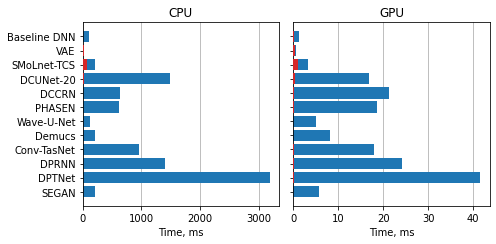

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 3.5))

ylabels = df['Model']
yticks = np.arange(len(ylabels))

for i, setup in enumerate(['CPU', 'GPU']):
    ax = axes[i]
    ax.barh(yticks, df[setup], align='center', zorder=2, color='tab:blue')
    ax.barh(yticks, df[setup+'_stft'], align='center', zorder=3, color='tab:red')
    ax.set_yticks(yticks)
    if i == 0:
        ax.set_yticklabels(df['Model'])
    else:
        ax.set_yticklabels(['']*len(ylabels))
        
    ax.invert_yaxis()
    ax.set_xlabel('Time, ms')
    ax.set_title(setup)
    ax.grid(which='both', axis='x', zorder=0)

fig.tight_layout()
plt.savefig('perf_eval.pdf', bbox_inches='tight')
plt.show()

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating UNetGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


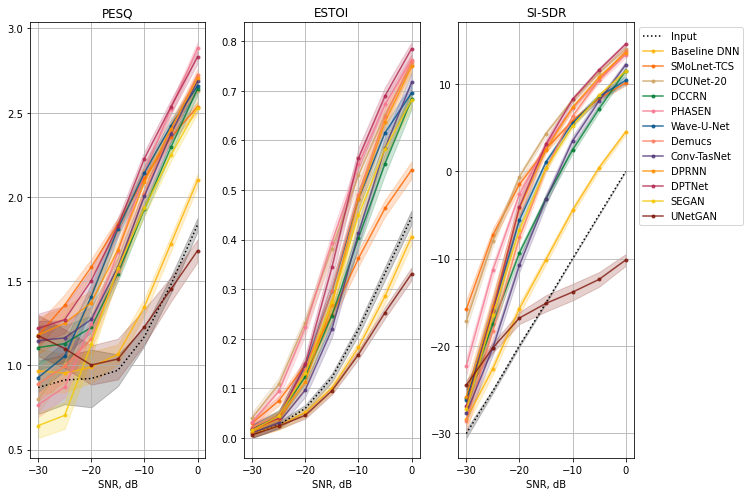

In [21]:
eval_all_and_plot(models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  num_workers=10, use_pypesq=True, figsize=(9, 7))

In [32]:
stationary_ixs = timit_test_small.mapping[:, 1].astype(bool)
nonstationary_ixs = np.logical_not(stationary_ixs)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating UNetGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


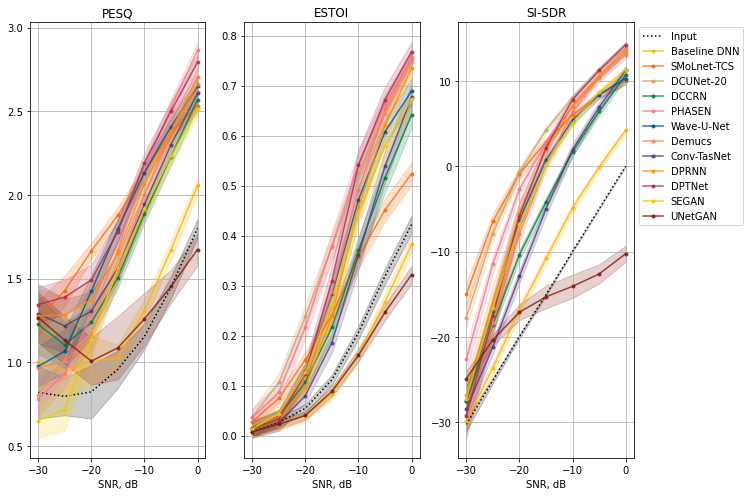

In [33]:
eval_all_and_plot(models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  num_workers=10, use_pypesq=True, figsize=(9, 7), subset_ixs=stationary_ixs)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Baseline DNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCUNet-20
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DCCRN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating PHASEN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Wave-U-Net
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Demucs
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating Conv-TasNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPRNN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating DPTNet
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SEGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating UNetGAN
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


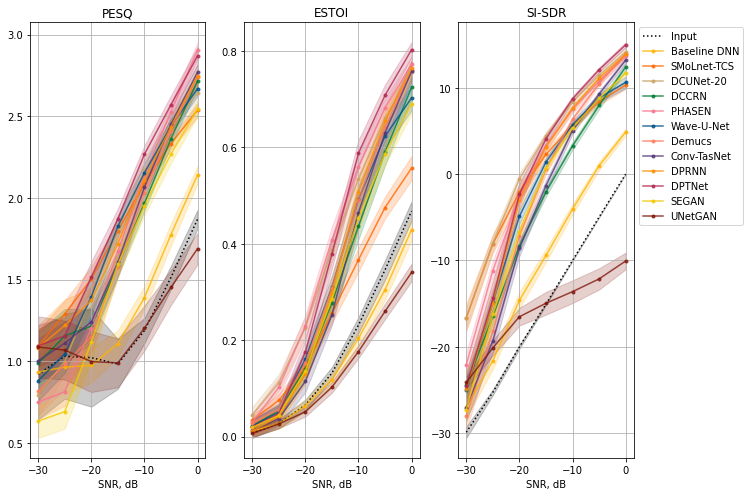

In [34]:
eval_all_and_plot(models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  num_workers=10, use_pypesq=True, figsize=(9, 7), subset_ixs=nonstationary_ixs)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 256)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 64)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']
Evaluating SMoLnet-TCS (max dilation 16)
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


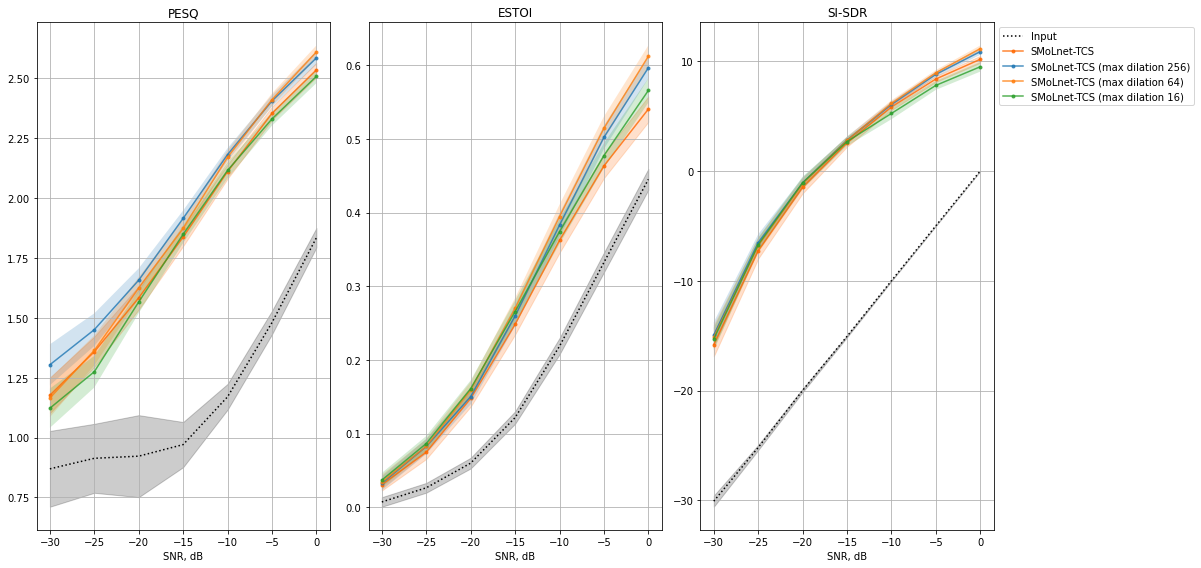

In [13]:
eval_all_and_plot(smolnet_dilations, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  num_workers=10, use_pypesq=True)

In [93]:
smolnet_dilations['smolnet_dil4']

SMoLnet(
  (encoder): Encoder(
    (filterbank): STFTFB()
  )
  (masker): Sequential(
    (0): SMoLnetDilatedLayer(
      (main): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): SMoLnetDilatedLayer(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(2, 0), dilation=(2, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): SMoLnetDilatedLayer(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=(4, 0), dilation=(4, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): SMoLnetDilatedLayer(
      (main): Sequential(
   

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Wave-U-Net
Results already available
Evaluating DCUNet-20
Results already available
Evaluating SMoLnet
Results already available
Evaluating DPTNet
Results already available
Evaluating UNetGAN generator (MSE loss only)
Results already available
Evaluating UNetGAN
Results already available


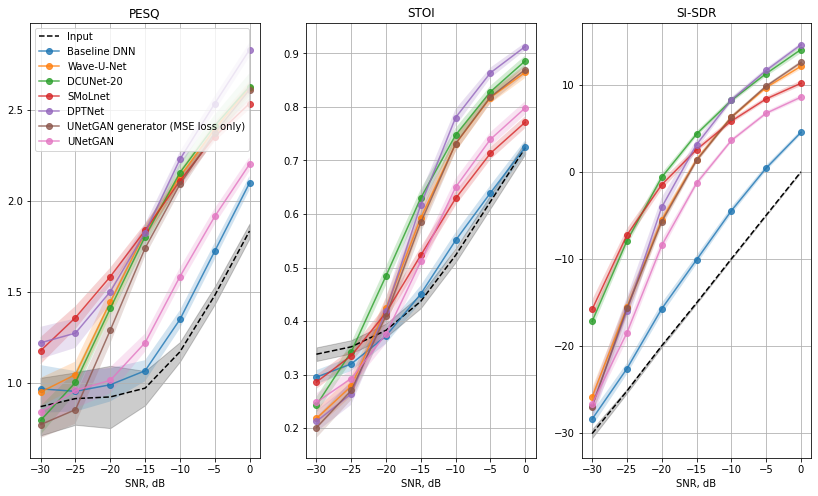

In [17]:
fewer_models = {
    k: models[k] for k in 
    ['input', 'baseline', 'waveunet_v1', 'dcunet_20', 'smolnet', 'dptnet', 'unetgan-nogan', 'unetgan']
}

eval_all_and_plot(fewer_models, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  plot_name='results_new_small.pdf', num_workers=5, use_pypesq=True)

Evaluating Input
Metrics already calculated:  ['pesq', 'estoi', 'si_sdr']


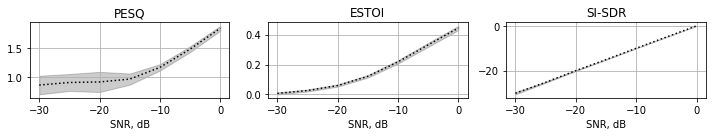

In [33]:
eval_all_and_plot({'input': None}, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',
                  plot_name='metrics_std2.pdf',
                  num_workers=5, use_pypesq=True, figsize=(10, 2), legend=False)

In [34]:
len(timit_test)

23520

In [35]:
len(timit_test_small)

1176

In [ ]:
eval_all()

Evaluating Input
Results already available
Evaluating Baseline DNN
Results already available
Evaluating Baseline DNN v2
Results already available
Evaluating Baseline DNN (sigm)
Results already available


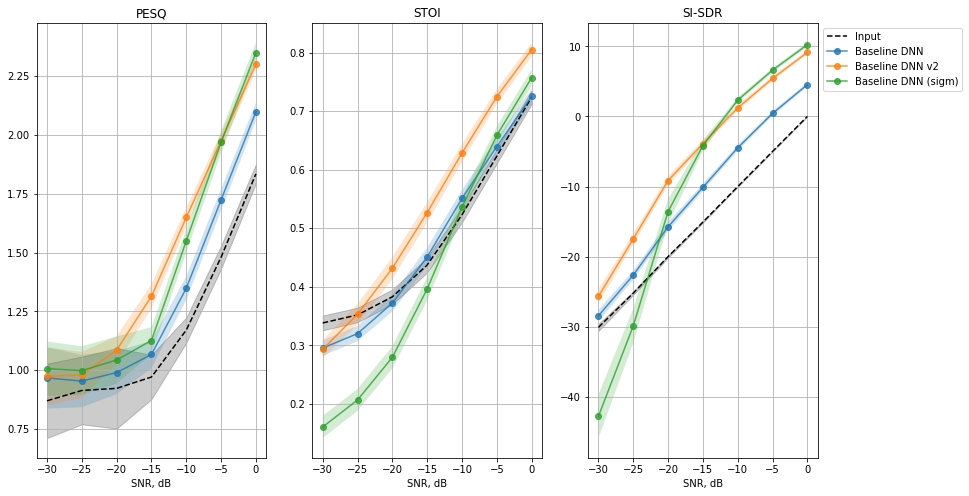

<ipython-input-44-a127d0c0c375>:75: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if s.dtype == np.object:
<ipython-input-44-a127d0c0c375>:75: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if s.dtype == np.object:
<ipython-input-44-a127d0c0c375>:75: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details an

In [51]:
eval_all_and_plot({'input'}, timit_test_small, '../../../workspace/eval_results_new_small_pypesq',  num_workers=10, use_pypesq=True)

### Receptive fields

In [33]:
def calc_rec_field_conv(layers, prev_r=(1,1), prev_stride=(1,1)):
    rs = []
    for i, (kernel_size, stride, dilation) in enumerate(layers):        
        r_0 = (kernel_size[0]-1)*dilation[0]*prev_stride[0] + (prev_r[0] - 1) + 1
        r_1 = (kernel_size[1]-1)*dilation[1]*prev_stride[1] + (prev_r[1] - 1) + 1
        
        prev_r = (r_0, r_1)
        prev_stride = stride
        rs.append(prev_r)
    
    return rs

def calc_rec_field_tconv(layers, prev_r=(1,1)):
    rs = []
    for i, (kernel_size, stride, dilation) in enumerate(layers):        
        r_0 = (kernel_size[0]-1)*dilation[0] // stride[0] + (prev_r[0] - 1) + 1
        r_1 = (kernel_size[1]-1)*dilation[0] // stride[1] + (prev_r[1] - 1) + 1
        
        prev_r = (r_0, r_1)
        prev_stride = stride
        rs.append(prev_r)
    
    return rs

def calc_rec_field_unet(encoders, decoders, middle=None):
    rs = calc_rec_field_conv(encoders)
    prev_r = rs[-1]
    
    if middle is not None:
        mid_rs = calc_rec_field_conv(middle, prev_r=prev_r)
        prev_r = mid_rs[-1]
    else:
        mid_rs = []
    
    t_rs = []
    for i, (kernel_size, stride, dilation) in enumerate(decoders):
        # max from main path and skip path
        max_r = max(prev_r[0], rs[-i-1][0]), max(prev_r[1], rs[-i-1][1])
        
        r_0 = (kernel_size[0]-1)*dilation[0] // stride[0] + (prev_r[0] - 1) + 1
        r_1 = (kernel_size[1]-1)*dilation[0] // stride[1] + (prev_r[1] - 1) + 1
        
        prev_r = (r_0, r_1)
        prev_stride = stride
        t_rs.append(prev_r)
    
    return rs + mid_rs + t_rs

In [34]:
smolnet_layers = [((3, 1), (1, 1), (2**i, 1)) for i in range(10)] + [((3, 3), (1,1), (1, 1))]*3
smolnet_layers_256 = [((3, 1), (1, 1), (2**i, 1)) for i in range(9)] + [((3, 1), (1, 1), (256, 1))] + [((3, 3), (1,1), (1, 1))]*3
smolnet_layers_64 = [((3, 1), (1, 1), (2**i, 1)) for i in range(7)] + [((3, 1), (1, 1), (64, 1))]*3 + [((3, 3), (1,1), (1, 1))]*3
smolnet_layers_16 = [((3, 1), (1, 1), (2**i, 1)) for i in range(5)] + [((3, 1), (1, 1), (16, 1))]*5 + [((3, 3), (1,1), (1, 1))]*3
smolnet_layers_4 = [((3, 1), (1, 1), (2**i, 1)) for i in range(3)] + [((3, 1), (1, 1), (4, 1))]*7 + [((3, 3), (1,1), (1, 1))]*3
smolnet_layers_1 = [((3, 1), (1, 1), (1, 1))]*10 + [((3, 3), (1,1), (1, 1))]*3

smolnets = [smolnet_layers, smolnet_layers_256, smolnet_layers_64, smolnet_layers_16, smolnet_layers_4, smolnet_layers_1]

dcunet_encoder_layers = [
    ((7, 1), (1, 1), (1, 1)),
    ((1, 7), (1, 1), (1, 1)),
    ((7, 5), (2, 2), (1, 1)),
    ((7, 5), (2, 1), (1, 1)),
    ((5, 3), (2, 2), (1, 1)),
    ((5, 3), (2, 1), (1, 1)),
    ((5, 3), (2, 2), (1, 1)),
    ((5, 3), (2, 1), (1, 1)),
    ((5, 3), (2, 2), (1, 1)),
    ((5, 3), (2, 1), (1, 1))
]
dcunet_decoder_layers = dcunet_encoder_layers[::-1]
dccrn_encoder_layers = [((5, 2), (2, 1), (1,1))]*6
dccrn_decoder_layers = [((5, 2), (2, 1), (1,1))]*6

In [35]:
smolnet_rec_fields = [calc_rec_field_conv(ls)[-1] for ls in smolnets]

In [36]:
smolnet_rec_fields

[(2053, 7), (1541, 7), (645, 7), (229, 7), (77, 7), (27, 7)]

In [37]:
[p[0] / 1025 * 4000 for p in smolnet_rec_fields]

[8011.707317073171,
 6013.658536585366,
 2517.0731707317073,
 893.6585365853658,
 300.4878048780488,
 105.36585365853658]

In [97]:
calc_rec_field_conv(dcunet_encoder_layers)

[(7, 1),
 (7, 7),
 (13, 11),
 (25, 19),
 (33, 21),
 (41, 25),
 (49, 27),
 (57, 31),
 (65, 33),
 (73, 37)]

In [98]:
calc_rec_field_unet(dcunet_encoder_layers, dcunet_decoder_layers)

[(7, 1),
 (7, 7),
 (13, 11),
 (25, 19),
 (33, 21),
 (41, 25),
 (49, 27),
 (57, 31),
 (65, 33),
 (73, 37),
 (75, 39),
 (77, 40),
 (79, 42),
 (81, 43),
 (83, 45),
 (85, 46),
 (88, 50),
 (91, 52),
 (91, 58),
 (97, 58)]

In [100]:
calc_rec_field_unet(dccrn_encoder_layers, dccrn_decoder_layers)

[(5, 2),
 (13, 3),
 (21, 4),
 (29, 5),
 (37, 6),
 (45, 7),
 (47, 8),
 (49, 9),
 (51, 10),
 (53, 11),
 (55, 12),
 (57, 13)]